In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths
original_dataset_path = "/kaggle/input/flowers/flowers"
base_dir = "/kaggle/working/"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Create directories for splits
def create_dir_structure(base_dir, class_names):
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        for class_name in class_names:
            os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

# Get class names (folder names)
class_names = [d for d in os.listdir(original_dataset_path) if os.path.isdir(os.path.join(original_dataset_path, d))]

# Create directory structure
create_dir_structure(base_dir, class_names)

# Split data
for class_name in class_names:
    class_path = os.path.join(original_dataset_path, class_name)
    images = os.listdir(class_path)
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
    train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.2, random_state=42)
    
    # Copy images to train/val/test folders
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name))

print("Dataset successfully split!")

# Image Parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Inspect Class Labels
class_labels = train_generator.class_indices
print("Class Indices:", class_labels)


Dataset successfully split!
Found 10062 images belonging to 16 classes.
Found 2524 images belonging to 16 classes.
Found 3154 images belonging to 16 classes.
Class Indices: {'astilbe': 0, 'bellflower': 1, 'black_eyed_susan': 2, 'calendula': 3, 'california_poppy': 4, 'carnation': 5, 'common_daisy': 6, 'coreopsis': 7, 'daffodil': 8, 'dandelion': 9, 'iris': 10, 'magnolia': 11, 'rose': 12, 'sunflower': 13, 'tulip': 14, 'water_lily': 15}


Counting images in train, val, and test sets...
Visualizing image counts...


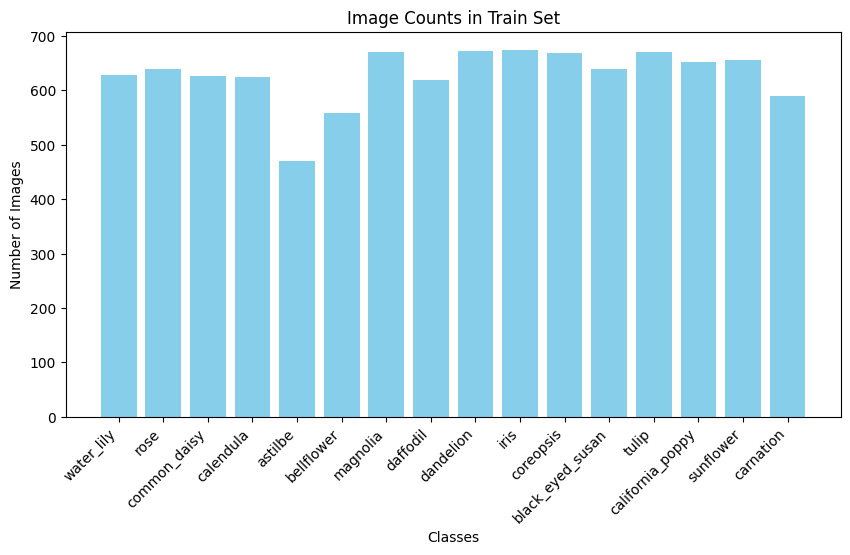

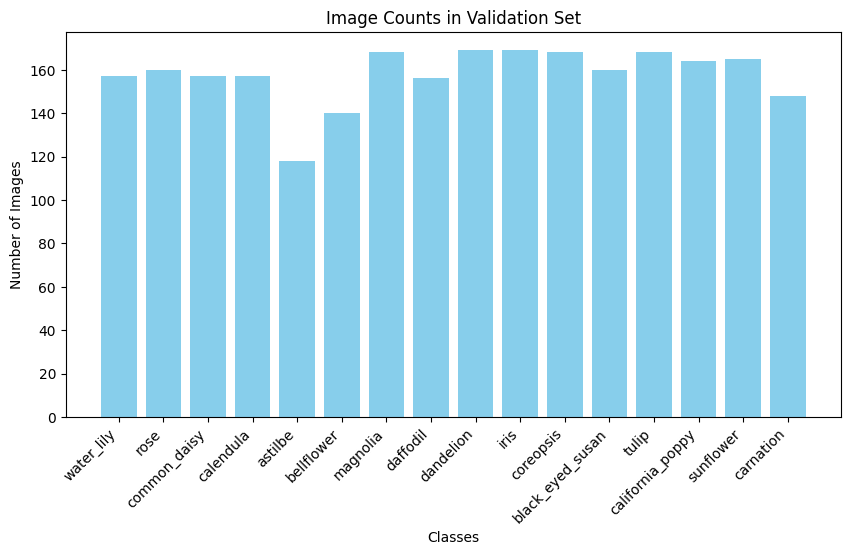

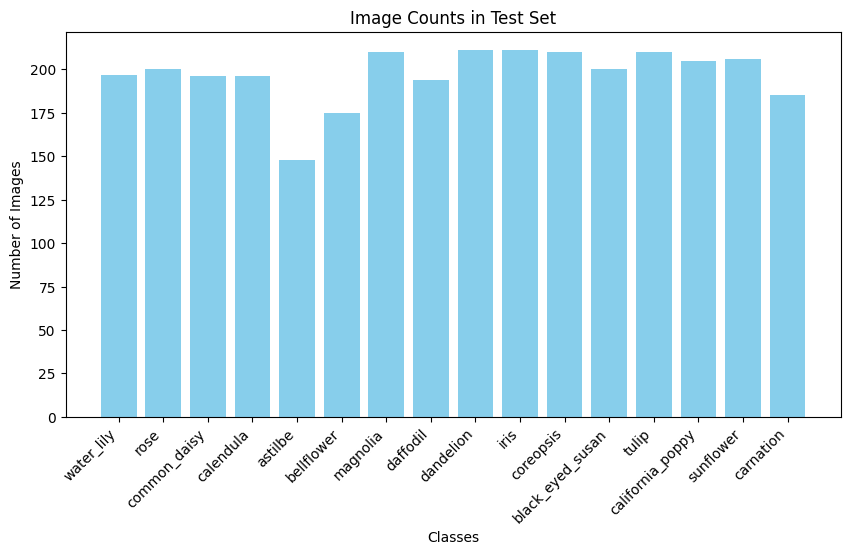

Displaying random images from train, val, and test sets...


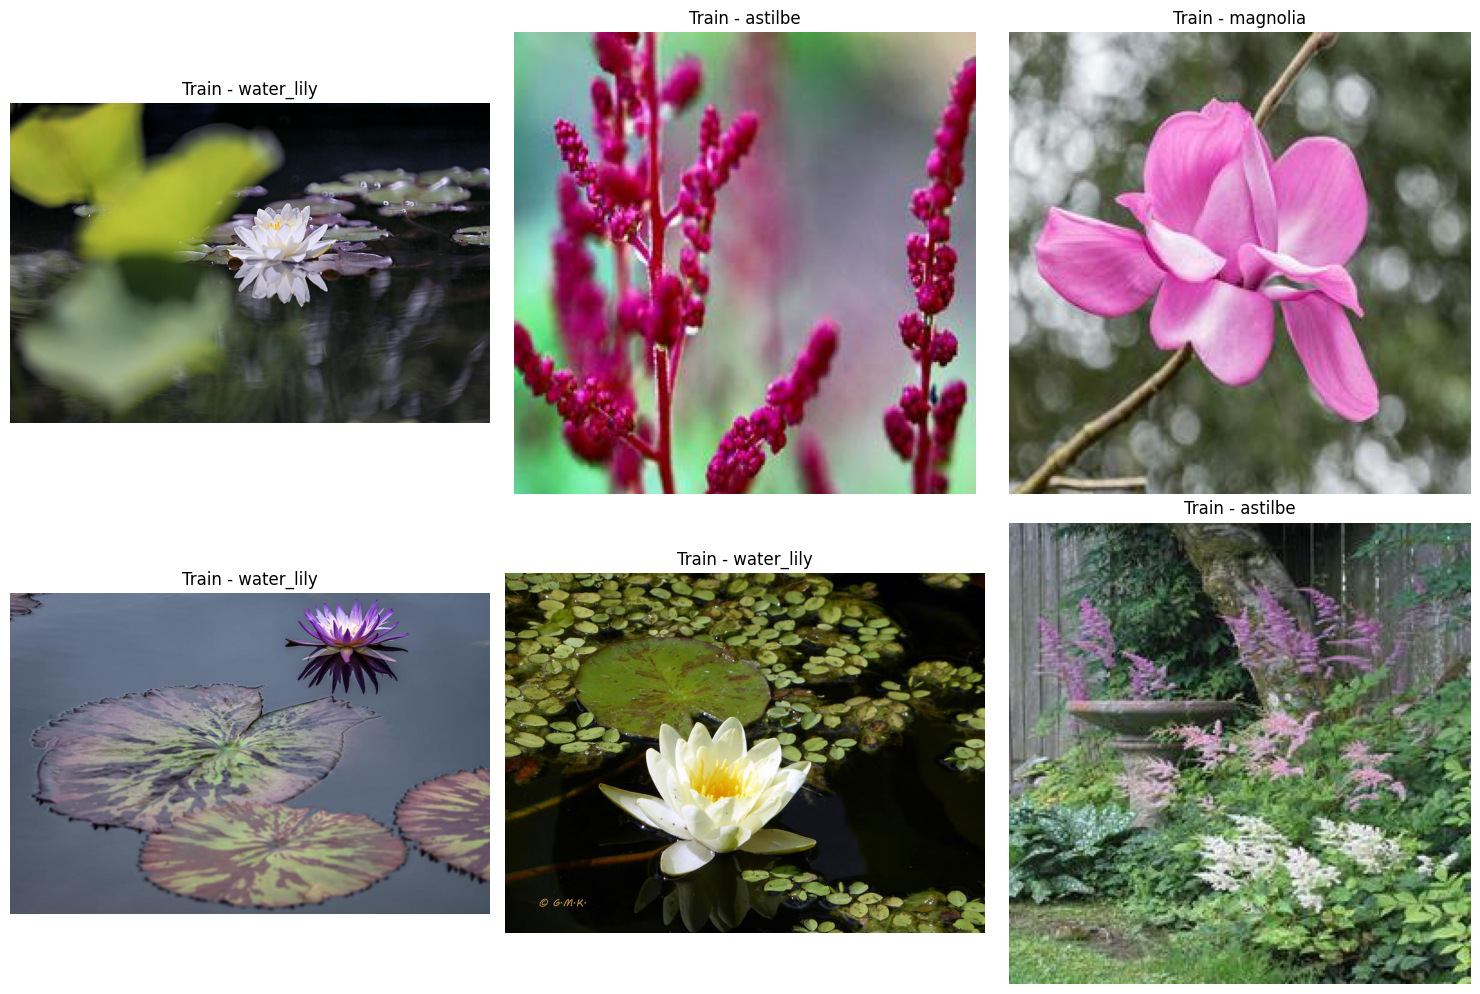

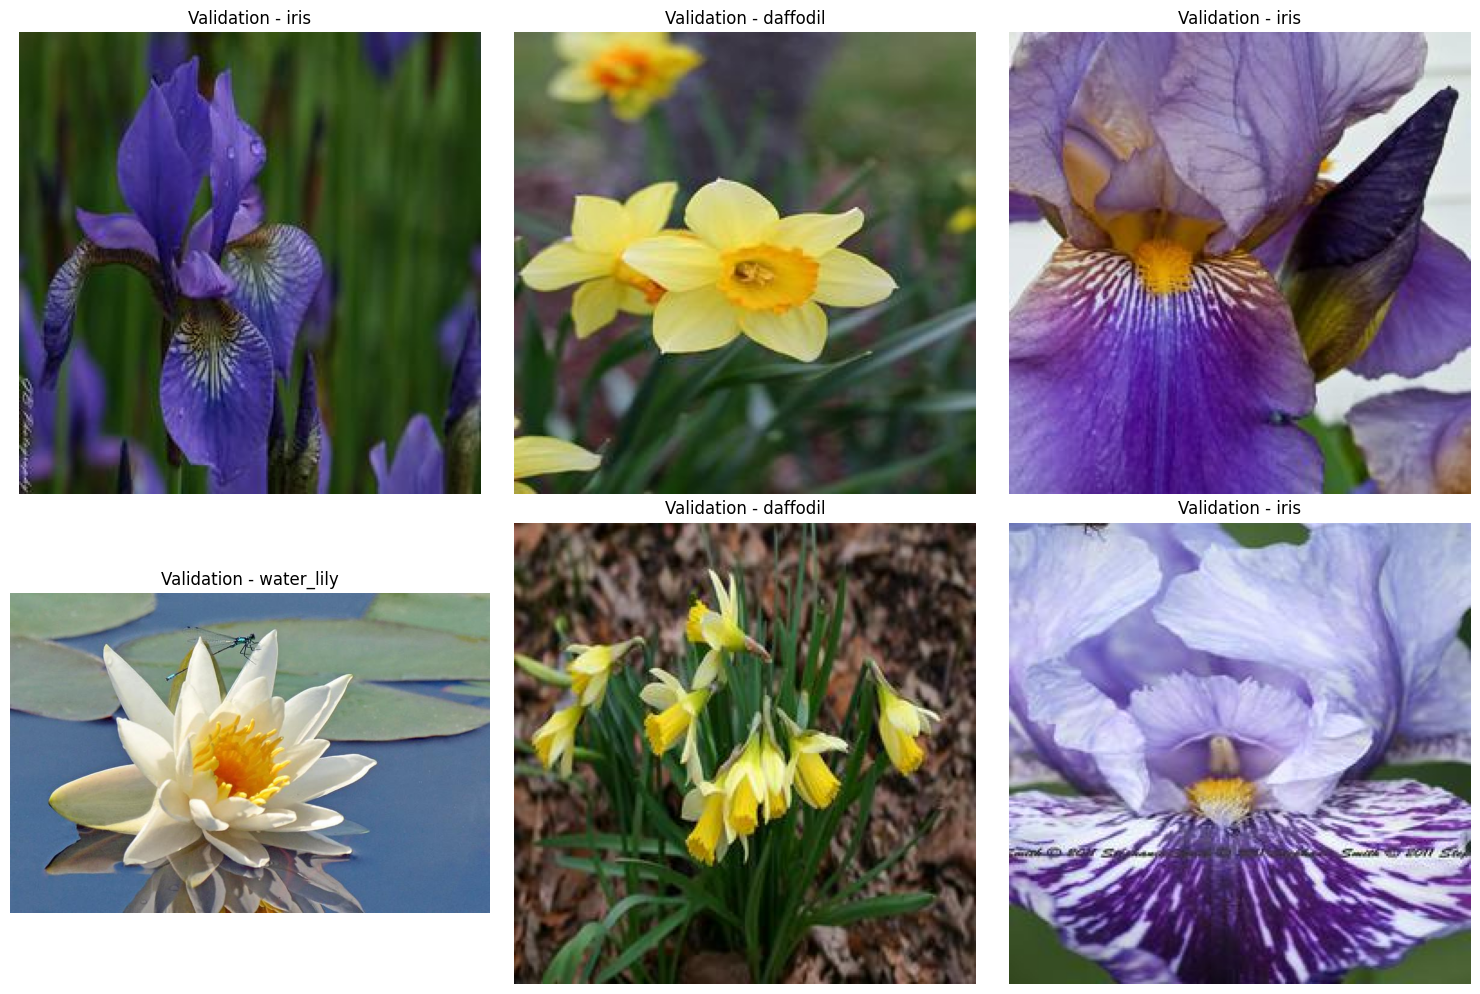

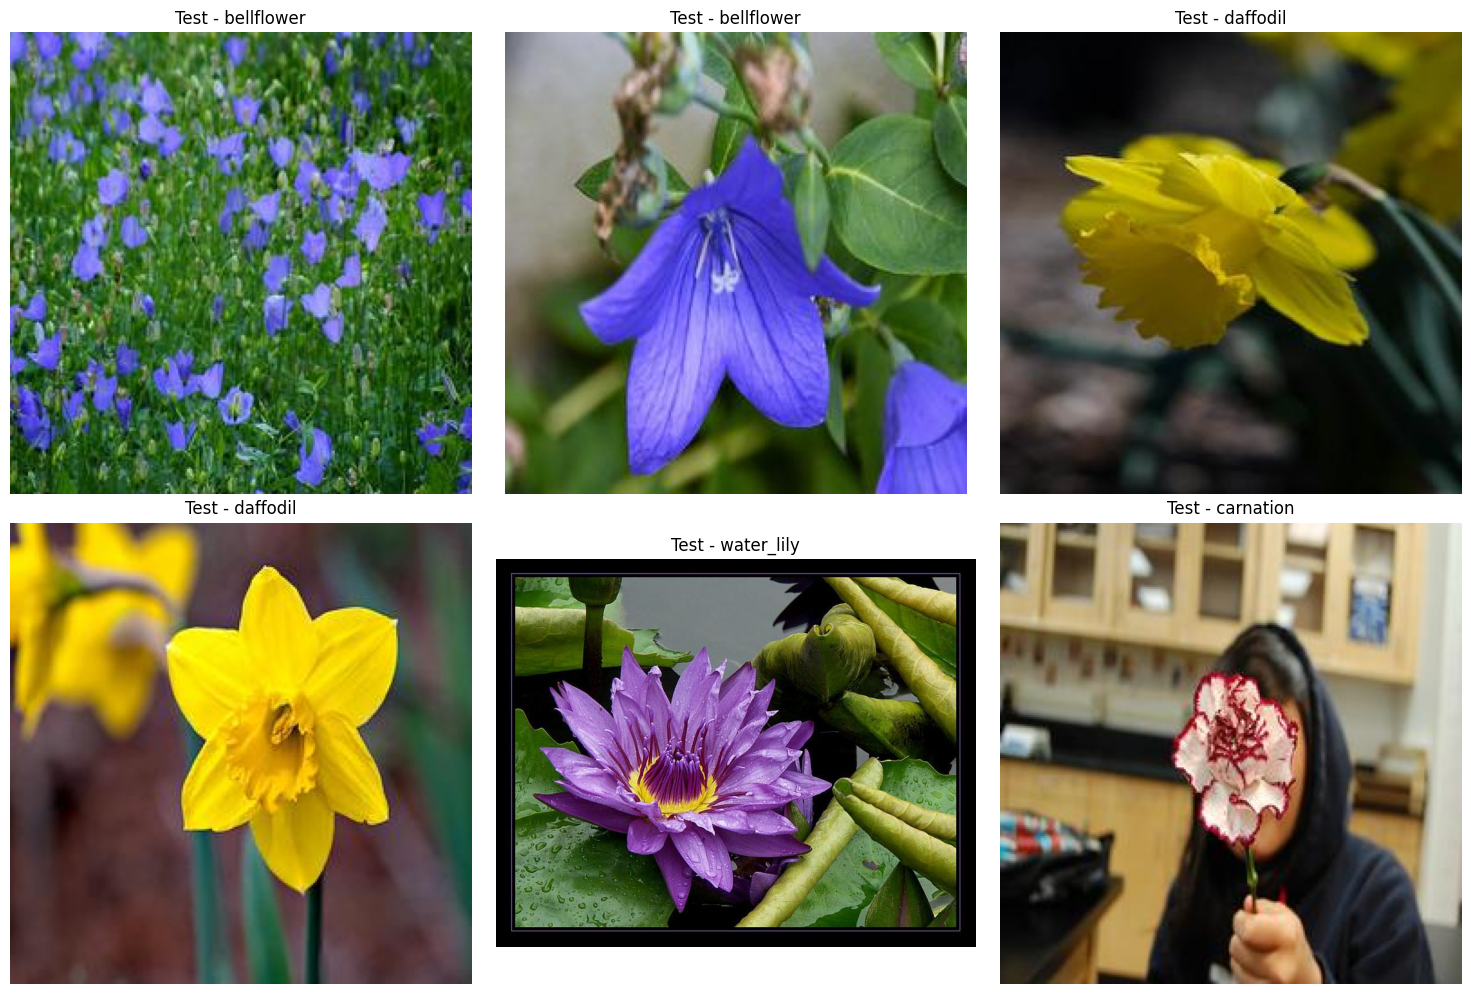

In [2]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Set paths for the split dataset
train_dir = "/kaggle/working/train"
val_dir = "/kaggle/working/val"
test_dir = "/kaggle/working/test"

# Count images per class in each split
def count_images_in_split(split_dir):
    counts = {}
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

# Visualize counts
def visualize_counts(counts, split_name):
    classes = list(counts.keys())
    image_counts = list(counts.values())
    plt.figure(figsize=(10, 5))
    plt.bar(classes, image_counts, color='skyblue')
    plt.title(f"Image Counts in {split_name} Set")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Number of Images")
    plt.xlabel("Classes")
    plt.show()

# Display random images
def display_random_images(split_dir, split_name):
    class_names = os.listdir(split_dir)
    plt.figure(figsize=(15, 10))
    for i in range(6):  # Display 6 random images
        random_class = random.choice(class_names)
        class_path = os.path.join(split_dir, random_class)
        random_image = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, random_image)
        img = Image.open(img_path)

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"{split_name} - {random_class}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Count and visualize dataset splits
print("Counting images in train, val, and test sets...")
train_counts = count_images_in_split(train_dir)
val_counts = count_images_in_split(val_dir)
test_counts = count_images_in_split(test_dir)

# Visualize counts
print("Visualizing image counts...")
visualize_counts(train_counts, "Train")
visualize_counts(val_counts, "Validation")
visualize_counts(test_counts, "Test")

# Display random images
print("Displaying random images from train, val, and test sets...")
display_random_images(train_dir, "Train")
display_random_images(val_dir, "Validation")
display_random_images(test_dir, "Test")


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Hyperparameters
IMG_SIZE = (224, 224)  # Input size for VGG
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4

# Data Augmentation and Normalization
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0
)

# Load the datasets
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Print class indices
print("Class Indices:", train_data.class_indices)
num_classes = len(train_data.class_indices)


Found 10062 images belonging to 16 classes.
Found 2524 images belonging to 16 classes.
Found 3154 images belonging to 16 classes.
Class Indices: {'astilbe': 0, 'bellflower': 1, 'black_eyed_susan': 2, 'calendula': 3, 'california_poppy': 4, 'carnation': 5, 'common_daisy': 6, 'coreopsis': 7, 'daffodil': 8, 'dandelion': 9, 'iris': 10, 'magnolia': 11, 'rose': 12, 'sunflower': 13, 'tulip': 14, 'water_lily': 15}


In [4]:
# Load pre-trained VGG16 model (excluding top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (no training for pre-trained layers)
base_model.trainable = False

# Build custom model on top of VGG16
model = Sequential([
    base_model,
    Flatten(),  # Flatten feature maps
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define a checkpoint callback to save the best model
checkpoint_path = "vgg16_flower_classifier_checkpoint.keras"
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,       # Save only if validation loss improves
    monitor="val_loss",        # Monitor validation loss
    mode="min",                # Save model when val_loss decreases
    verbose=1                  # Print a message when the model is saved
)

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model with both callbacks
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint]  # Include the checkpoint callback
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733984935.454276     130 service.cc:145] XLA service 0x5a54c06731a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733984935.454356     130 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/315 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.0781 - loss: 3.6470   

I0000 00:00:1733984947.251613     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.2548 - loss: 2.6793
Epoch 1: val_loss improved from inf to 1.20939, saving model to vgg16_flower_classifier_checkpoint.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 135s 376ms/step - accuracy: 0.2551 - loss: 2.6779 - val_accuracy: 0.6391 - val_loss: 1.2094
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.5045 - loss: 1.6074
Epoch 2: val_loss improved from 1.20939 to 0.91847, saving model to vgg16_flower_classifier_checkpoint.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 107s 332ms/step - accuracy: 0.5046 - loss: 1.6071 - val_accuracy: 0.7345 - val_loss: 0.9185
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.5827 - loss: 1.3517
Epoch 3: val_loss improved from 0.91847 to 0.83221, saving model to vgg16_flower_classifier_checkpoint.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 107s 333ms/step - accuracy: 0.5827 - loss: 1.3516 - val_accuracy: 0.7500 - val_loss: 0.8322
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accur

In [6]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Save the model
model.save("vgg16_flower_classifier.h5")
print("Model saved as vgg16_flower_classifier.h5")


99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.8583 - loss: 0.4755
Test Accuracy: 0.85
Model saved as vgg16_flower_classifier.h5


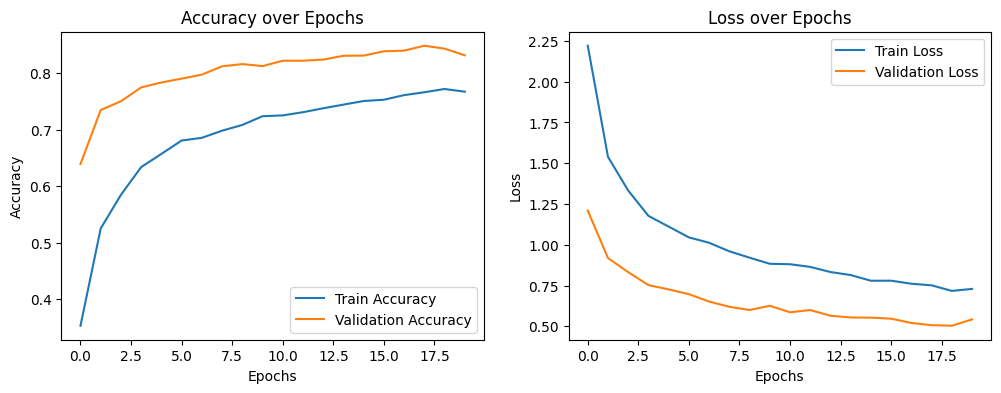

In [7]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [8]:
# Unfreeze some layers in the base model
base_model.trainable = True

# Re-compile with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train again
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,  # Fine-tune for fewer epochs
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]
)


Epoch 1/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 135s 364ms/step - accuracy: 0.7900 - loss: 0.6622 - val_accuracy: 0.8847 - val_loss: 0.3932
Epoch 2/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 108s 336ms/step - accuracy: 0.8338 - loss: 0.5212 - val_accuracy: 0.8926 - val_loss: 0.3465
Epoch 3/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 108s 336ms/step - accuracy: 0.8657 - loss: 0.4206 - val_accuracy: 0.9077 - val_loss: 0.3029
Epoch 4/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 108s 334ms/step - accuracy: 0.8867 - loss: 0.3680 - val_accuracy: 0.9263 - val_loss: 0.2520
Epoch 5/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 109s 338ms/step - accuracy: 0.9014 - loss: 0.3288 - val_accuracy: 0.9109 - val_loss: 0.2927


In [9]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Save the model
model.save("vgg16_flower_classifier.h5")
print("Model saved as vgg16_flower_classifier.h5")


99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9178 - loss: 0.2651
Test Accuracy: 0.92
Model saved as vgg16_flower_classifier.h5


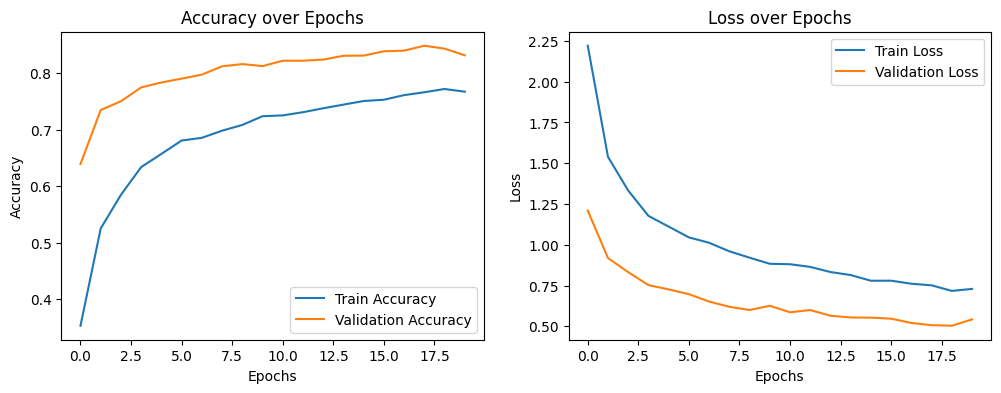

In [10]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
